In [1]:
import matplotlib.pyplot as plt
import os
from os.path import basename, dirname, join
import numpy as np
import pandas as pd
import logging
import shutil
from random import choice

# from uavsar_pytools.download.download import download_zip
# from uavsar_pytools.convert.file_control import unzip
# from uavsar_pytools.convert.tiff_conversion import grd_tiff_convert
# from uavsar_pytools.uavsar_image import UavsarImage

log = logging.getLogger(__name__)
logging.basicConfig()
log.setLevel(logging.DEBUG)

In [4]:




"""
Improved functions convert polsar, insar, and other associated UAVSAR files from binary format to geoTIFFS in WGS84.
"""

import os
from os.path import isdir, exists, basename, dirname, join, isfile
from glob import glob
from re import L
from matplotlib.pyplot import polar
from tqdm import tqdm
import numpy as np
import pandas as pd
import pytz
import rasterio
from rasterio.transform import Affine
from rasterio.crs import CRS
from pyproj import Geod, Proj
import logging

log = logging.getLogger(__name__)
logging.basicConfig()

def get_encapsulated(str_line, encapsulator):
    """
    Returns items found in the encapsulator, useful for finding units
    Originally written by Micah J. Amended for uavsar_pytools by Zach Keskinen.
    Args:
        str_line: String that has encapusulated info we want removed
        encapsulator: string of characters encapusulating info to be removed
    Returns:
        result: list of strings found inside anything between encapsulators
    e.g.
        line = 'density (kg/m^3), temperature (C)'
        ['kg/m^3', 'C'] = get_encapsulated(line, '()')
    """

    result = []

    if len(encapsulator) > 2:
        raise ValueError('encapsulator can only be 1 or 2 chars long!')

    elif len(encapsulator) == 2:
        lcap = encapsulator[0]
        rcap = encapsulator[1]

    else:
        lcap = rcap = encapsulator

    # Split on the lcap
    if lcap in str_line:
        for i, val in enumerate(str_line.split(lcap)):
            # The first one will always be before our encapsulated
            if i != 0:
                if lcap != rcap:
                    result.append(val[0:val.index(rcap)])
                else:
                    result.append(val)

    return result

def read_annotation(ann_file):
    """
    .ann files describe the INSAR data. Use this function to read all that
    information in and return it as a dictionary
    Originally written by Micah J. Amended for uavsar_pytools by Zach Keskinen.

    Expected format:
    `DEM Original Pixel spacing (arcsec) = 1`
    Where this is interpretted as:
    `key (units) = [value]`
    Then stored in the dictionary as:
    `data[key] = {'value':value, 'units':units}`
    values that are found to be numeric and have a decimal are converted to a
    float otherwise numeric data is cast as integers. Everything else is left
    as strings.
    Args:
        ann_file: path to UAVSAR annotation file
    Returns:
        data: Dictionary containing a dictionary for each entry with keys
              for value, units and comments
    """

    with open(ann_file) as fp:
        lines = fp.readlines()
        fp.close()
    data = {}

    # loop through the data and parse
    for line in lines:

        # Filter out all comments and remove any line returns
        info = line.strip().split(';')
        comment = info[-1].strip().lower()
        info = info[0]
        # ignore empty strings
        if info and "=" in info:
            d = info.split('=')
            name, value = d[0], d[1]
            # Clean up tabs, spaces and line returns
            key = name.split('(')[0].strip().lower()
            units = get_encapsulated(name, '()')
            if not units:
                units = None
            else:
                units = units[0]

            value = value.strip()

            # Cast the values that can be to numbers ###
            if value.strip('-').replace('.', '').isnumeric():
                if '.' in value:
                    value = float(value)
                else:
                    value = int(value)

            # Assign each entry as a dictionary with value and units
            data[key] = {'value': value, 'units': units, 'comment': comment}

    # Convert times to datetimes
    if 'start time of acquistion for pass 1' in data.keys():
        for pass_num in ['1', '2']:
            for timing in ['start', 'stop']:
                key = f'{timing} time of acquisition for pass {pass_num}'
                dt = pd.to_datetime(data[key]['value'])
                dt = dt.astimezone(pytz.timezone('US/Mountain'))
                data[key]['value'] = dt
    elif 'start time of acquisition' in data.keys():
        for timing in ['start', 'stop']:
                key = f'{timing} time of acquisition'
                dt = pd.to_datetime(data[key]['value'])
                dt = dt.astimezone(pytz.timezone('US/Mountain'))
                data[key]['value'] = dt

    return data

def grd_tiff_convert(in_fp, out_dir, ann_fp = None, overwrite = 'user', debug = False):
    """
    Converts a single binary image either polsar or insar to geotiff.
    See: https://uavsar.jpl.nasa.gov/science/documents/polsar-format.html for polsar
    and: https://uavsar.jpl.nasa.gov/science/documents/rpi-format.html for insar
    and: https://uavsar.jpl.nasa.gov/science/documents/stack-format.html for SLC stacks.
    Originally written by Micah J. Amended for uavsar_pytools by Zach Keskinen.

    Args:
        in_fp (string): path to input binary file
        out_dir (string): directory to save geotiff in
        ann_fp (string): path to UAVSAR annotation file
    """
    if debug:
        log.setLevel(logging.DEBUG)
    else:
        log.setLevel(logging.WARNING)
    print(in_fp,"in_fp\n")
    print(basename(in_fp))
    print("This is out dir valuuuuuuuuuuuuueeeee",out_dir," this is in_fp ",in_fp,sep=" ")
    out_fp = join(out_dir+r"/"+basename(in_fp)) + '.tiff'
    print(out_fp,"out_fp\n")
    

    #Determine type of image
    if isfile(out_dir):
        raise Exception('Provide filepath not the directory.')
    
    if not exists(in_fp):
        raise Exception(f'Input file path: {in_fp} does not exist.')

    exts = basename(in_fp).split('.')[1:]
    print(exts)
    if len(exts) == 2:
        ext = exts[1]
        type = exts[0]
    elif len(exts) == 1:
        type = ext = exts[0]
    else:
        raise ValueError('Unable to parse extensions')
    log.info(f'Extenstion: {ext}, type : {type}')
    
    # Find annotation file in same directory if no user given one
    if not ann_fp:
        if ext == 'grd' or ext == 'slc':
            ann_fp = in_fp.replace(f'.{type}', '').replace(f'.{ext}', '.ann')
        else:
            ann_fp = in_fp.replace(f'.{ext}', '.ann')
        if not exists(ann_fp):
            search_base = '_'.join(basename(in_fp).split('.')[0].split('_')[:4])
            search_full = os.path.join(os.path.dirname(in_fp), f'{search_base}*.ann')
            log.debug(f'Glob search: {search_full}')
            ann_search = glob(search_full)
            if len(ann_search) == 1:
                ann_fp = ann_search[0]
            else:
                raise Exception('No ann file found in directory. Please specify ann filepath.')
        else:
            log.info(f'No annotation file path specificed. Using f{ann_fp}.')

    # Check for compatible extensions
    if type == 'zip':
        raise Exception('Can not convert zipped directories. Unzip first.')
    if type == 'dat' or type == 'kmz' or type == 'kml' or type == 'png' or type == 'tif':
        raise Exception(f'Can not handle {type} products')
    if type == 'ann':
        raise Exception(f'Can not convert annotation files.')

    # Check for slant range files and ancillary files
    anc = None
    if type == 'slope' or type == 'inc':
        anc = True
        log.info(f'Identified as ancillary')
    # Check if file already exists and for overwriting
    ans = 'N'
    if exists(out_fp):
            if overwrite == True:
                ans = 'y'
            elif overwrite == False:
                ans = 'n'
            else:
                ans = input(f'\nWARNING! You are about overwrite {out_fp}!.  '
                            f'\nPress Y to continue and any other key to abort: ').lower()
            if ans == 'y':
                os.remove(out_fp)

    if ans == 'y' or exists(out_fp) == False:

        # Read in annotation file
        desc = read_annotation(ann_fp)
        #pd.DataFrame.from_dict(desc).to_csv('../data/test.csv')
        if 'start time of acquisition for pass 1' in desc.keys():
            mode = 'insar'
        else:
            mode = 'polsar'
        log.info(f'Working with {mode}')

        # Determine the correct file typing for searching our data dictionary
        if not anc:
            if mode == 'polsar':
                if type == 'hgt':
                    search = type
                else:
                    polarization = basename(in_fp).split('_')[5][-4:]
                    if polarization == 'HHHH' or polarization == 'HVHV' or polarization == 'VVVV':
                            search = f'{type}_pwr'
                    else:
                        search = f'{type}_phase'
                    type = polarization

            elif mode == 'insar':
                if ext == 'grd':
                    if type == 'int':
                        search = f'grd_phs'
                    else:
                        search = 'grd'
                else:
                    if type == 'int':
                        search = 'slt_phs'
                    else:
                        search = 'slt'
        else:
            search = type

        log.debug(f'Searching with: {search}')

        # Pull the appropriate values from our annotation dictionary
        nrow = desc[f'{search}.set_rows']['value']
        ncol = desc[f'{search}.set_cols']['value']
        log.debug(f'rows: {nrow} x cols: {ncol} pixels')

        if ext == 'grd' or anc:
            # Ground projected images
            # Delta latitude and longitude
            dlat = desc[f'{search}.row_mult']['value']
            dlon = desc[f'{search}.col_mult']['value']
            log.debug(f'latitude delta: {dlat}, longitude delta: {dlon} deg/pixel')
            # Upper left corner coordinates
            lat1 = desc[f'{search}.row_addr']['value']
            lon1 = desc[f'{search}.col_addr']['value']
            log.debug(f'Ref Latitude: {lat1}, Longitude: {lon1} degrees')

            # Lat1/lon1 are already the center so for geotiff were good to go.
            t = Affine.translation(float(lon1), float(lat1))* Affine.scale(float(dlon), float(dlat))

            # Build the transform and CRS
            crs = CRS.from_user_input("EPSG:4326")

        # Get data type specific data
        bytes = desc[f'{search}.val_size']['value']
        endian = desc['val_endi']['value']
        log.debug(f'Bytes = {bytes}, Endian = {endian}')

        # Set up datatypes
        com_des = desc[f'{search}.val_frmt']['value']
        com = False
        if 'COMPLEX' in com_des:
            com = True
        log.debug(f'Complex descriptor {com_des}')
        if com:
            dtype = np.complex64
        else:
            dtype = np.float32
        log.debug(f'Data type = {dtype}')
        # Read in binary data
        z = np.fromfile(in_fp, dtype = dtype)

        # Reshape it to match what the text file says the image is
        if type == 'slope':
            z[z==-10000]= np.nan
            slopes = {}
            slopes['east'] = z[::2].reshape(nrow, ncol)
            slopes['north'] = z[1::2].reshape(nrow, ncol)
        else:
            slopes = None
            z = z.reshape(nrow, ncol)


        # Change zeros and -10,000 to nans based on documentation.
        if com:
            z[z== 0 + 0*1j] = np.nan + np.nan * 1j
        else:
            z[z==0]= np.nan
            z[z==-10000]= np.nan

        if slopes:
            slope_fps = []
            for direction, array in slopes.items():
                slope_fp = out_fp.replace('.tiff',f'.{direction}.tiff')
                log.debug(f'Writing to {slope_fp}...')
                dataset = rasterio.open(
                slope_fp,
                'w+',
                driver='GTiff',
                height=array.shape[0],
                width=array.shape[1],
                count=1,
                dtype=dtype,
                crs=crs,
                transform=t,)
                # Write out the data
                dataset.write(array, 1)

                dataset.close()
                slope_fps.append(slope_fp)
            return desc, z, type, slope_fps
        else:
            log.debug(f'Writing to {out_fp}...')

            if ext == 'grd' or anc:
                print(out_fp," loafer output path")
                dataset = rasterio.open(
                    out_fp,
                    'w+',
                    driver='GTiff',
                    height=z.shape[0],
                    width=z.shape[1],
                    count=1,
                    dtype=dtype,
                    crs=crs,
                    transform=t,)
                log.info('Finished converting image to WGS84 Geotiff.')
            else:
                dataset = rasterio.open(
                    out_fp,
                    'w+',
                    driver='GTiff',
                    height=z.shape[0],
                    width=z.shape[1],
                    count=1,
                    dtype=dtype,)
            # Write out the data
            dataset.write(z, 1)

            dataset.close()

        return desc, z, type, out_fp

def array_to_tiff(arr, out_fp, desc, type):
    # Pull the appropriate values from our annotation dictionary
    nrow = desc[f'{type}.set_rows']['value']
    ncol = desc[f'{type}.set_cols']['value']
    # Pixel spacing
    dlat = desc[f'{type}.row_mult']['value']
    dlon = desc[f'{type}.col_mult']['value']
    # Upper left corner coordinates
    lat1 = desc[f'{type}.row_addr']['value']
    lon1 = desc[f'{type}.col_addr']['value']
    # Lat1/lon1 are already the center so for geotiff were good to go.
    t = Affine.translation(float(lon1), float(lat1))* Affine.scale(float(dlon), float(dlat))
    # Build the transform and CRS
    crs = CRS.from_user_input("EPSG:4326")

    dataset = rasterio.open(
        out_fp,
        'w+',
        driver='GTiff',
        height=arr.shape[0],
        width=arr.shape[1],
        count=1,
        dtype=arr.dtype,
        crs=crs,
        transform=t,
    )
    # Write out the data
    dataset.write(arr, 1)

    dataset.close()

In [33]:
def binary_to_tiffs(binary_dir=None,ann_fp = None):
        images={}
        tmp_dir="/tmp"
        clean=True
        low_ram=True
        # wdir = r"C:/Users/abhis.000/Desktop/pending/nisar"
        """
        Convert a set of binary images to WGS84 geotiffs.
        Args:
            sub_dir (str): sub-directory in working directory to put tiffs
            binary_dir (str): directory containing binary files. Autogenerated from unzipping.
        """
        pols = ['VV','VH','HV','HH']
        binary_fps = os.listdir(binary_dir)
        ann_dic=dict()
 
        out_dir = r"./falfa"

        if not os.path.exists(out_dir):
            os.makedirs(out_dir)

        if not ann_fp:
            ann_fps = [a for a in binary_fps if '.ann' in a]
            # ann_dic = {}
            for pol in pols:
                ann_pol = [fp for fp in ann_fps if pol in fp]
                if ann_pol:
                    ann_dic[pol] = ann_pol[0]

            if not ann_fps:
                log.warning('No annotation file found for binary files.')

        binary_img_fps = [f for f in binary_fps if (('.grd' in f or '.inc' in f))]
        print("testtesteste",binary_dir)
        for f in binary_img_fps:
            if len(ann_dic) > 0:
                f_pol = [pol for pol in pols if pol in basename(f)][0]
                ann_fp = ann_dic[f_pol]
            if not ann_fp:
                ann_fp = ann_fps[0]
            f=binary_dir+"/"+f
            desc, array, type, out_fp = grd_tiff_convert(f, out_dir, ann_fp = ann_fp, overwrite = True, debug=False)
            if low_ram:
                images[type] = {'description': desc, 'out_fp':out_fp, 'type':type}
            else:
                images[type] = {'description': desc, 'array':  array, 'out_fp':out_fp, 'type':type}
        out_dir = out_dir
        df = pd.DataFrame(choice(list(images.values()))['description'])
        df.to_csv(join(out_dir, "this" + '.csv'))
        # if clean:
        #     shutil.rmtree(dirname(tmp_dir))


In [34]:
binary_to_tiffs(r"./",r"./fsmitN_33410_22032_001_220815_L090_CX_02.ann")

testtesteste ./
.//fsmitN_33410_22032_001_220815_L090HHHH_CX_02.grd in_fp

fsmitN_33410_22032_001_220815_L090HHHH_CX_02.grd
This is out dir valuuuuuuuuuuuuueeeee ./falfa  this is in_fp  .//fsmitN_33410_22032_001_220815_L090HHHH_CX_02.grd
./falfa/fsmitN_33410_22032_001_220815_L090HHHH_CX_02.grd.tiff out_fp

['grd']
./falfa/fsmitN_33410_22032_001_220815_L090HHHH_CX_02.grd.tiff  loafer output path
.//fsmitN_33410_22032_001_220815_L090HHHV_CX_02.grd in_fp

fsmitN_33410_22032_001_220815_L090HHHV_CX_02.grd
This is out dir valuuuuuuuuuuuuueeeee ./falfa  this is in_fp  .//fsmitN_33410_22032_001_220815_L090HHHV_CX_02.grd
./falfa/fsmitN_33410_22032_001_220815_L090HHHV_CX_02.grd.tiff out_fp

['grd']
./falfa/fsmitN_33410_22032_001_220815_L090HHHV_CX_02.grd.tiff  loafer output path
.//fsmitN_33410_22032_001_220815_L090HHVV_CX_02.grd in_fp

fsmitN_33410_22032_001_220815_L090HHVV_CX_02.grd
This is out dir valuuuuuuuuuuuuueeeee ./falfa  this is in_fp  .//fsmitN_33410_22032_001_220815_L090HHVV_CX_02.gr

In [35]:
from glob import glob
from os.path import join
glob(join(r"./falfa", 'test', '*.tiff'))

[]

In [12]:
!pip uninstall uavsar_pytools

^C


In [36]:
import sys
# sys.path.insert(0, '/Users/zachkeskinen/Documents/uavsar_pytools/')
from uavsar_pytools.polsar import H_A_alpha_decomp
from os.path import join
wdir = r"./falfa"
H_A_alpha_decomp(r"./falfa", out_dir=r"./falfa/test", parralel=True)

INFO:uavsar_pytools.polsar:Collecting polsar stack
INFO:uavsar_pytools.polsar:Starting H, A, Alpha Calculations. Parralelized = True


[########################################] | 100% Completed | 3hr 10m
[########################################] | 100% Completed | 3hr 10m
[########################################] | 100% Completed | 3hr 10m
[########################################] | 100% Completed | 3hr 10m


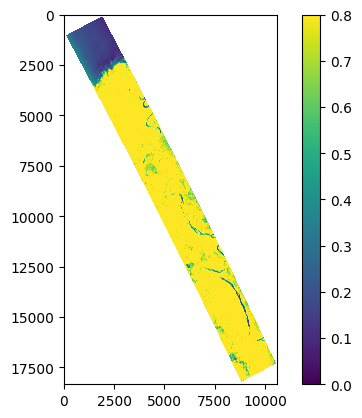

In [37]:
import numpy as np
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
f, ax = plt.subplots()
with rio.open(r"./falfa/test/entropy") as src:
    # show(src, ax = ax)
    c = ax.imshow(src.read(1), vmin = 0, vmax = 0.8)
    plt.colorbar(c)

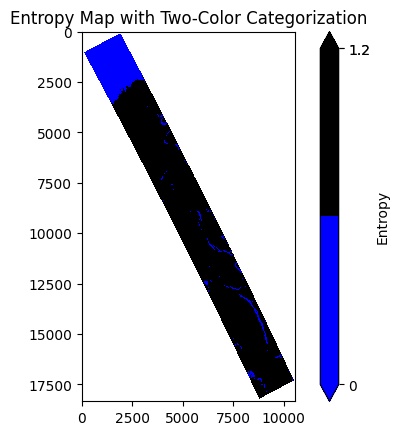

In [39]:
import numpy as np
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def create_two_color_colormap(vmin, vmax, colors):
    """
    Creates a custom colormap with two colors for a specific value range.

    Args:
        vmin (float): Minimum value for the color range.
        vmax (float): Maximum value for the color range.
        colors (tuple): A tuple containing two colors (e.g., ('blue', 'black')).

    Returns:
        matplotlib.colors.LinearSegmentedColormap: The custom colormap object.
    """

    cmap_name = "my_colormap"  # Optional name for the colormap
    return LinearSegmentedColormap.from_list(cmap_name, colors, N=2)

# Open the entropy file
with rio.open(r"./falfa/test/entropy") as src:
    data = src.read(1)  # Read the first band

# Create the custom colormap
vmin = 0  # Minimum value to display on the colorbar (optional)
vmax = 1.2  # Maximum value to display on the colorbar (optional)
colors = ("blue", "black")  # Colors for the two categories (0-0.2, 0.2-0.8)
custom_cmap = create_two_color_colormap(vmin, vmax, colors)

# Create the plot
fig, ax = plt.subplots()
c = ax.imshow(data, cmap=custom_cmap, vmin=vmin, vmax=vmax)  # Apply the custom colormap

# Create the colorbar (optional customization)
sm = plt.colorbar(c, label="Entropy", extend="both")  # Extend colorbar for values outside range

# Optional colorbar customization (adjust as needed)
sm.set_ticks([vmin, 0.6 , vmax])  # Set specific tick marks
sm.set_ticklabels(["0", "0.6", "1.2"])  # Set custom labels for tick marks

plt.title("Entropy Map with Two-Color Categorization")
plt.show()


In [ ]:
import numpy as np
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
import matplotlib.pyplot as plt

def lee_filter(img, size):
    """
    Applies Lee filter (speckle noise reduction) to an input image.

    Args:
        img (numpy.ndarray): Input image (grayscale).
        size (int): Size of the filter window (square).

    Returns:
        numpy.ndarray: Filtered image.
    """
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2
    overall_variance = variance(img)
    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

# Example usage
if __name__ == "__main__":
    # Generate a random noisy image
    img = np.random.normal(0.5, 0.1, (100, 100))
    img[:, :50] += 0.25

    # Apply Lee filter
    filtered_img = lee_filter(img, size=20)

    # Display original and filtered images
    plt.subplot(1, 2, 1)
    plt.imshow(img, vmin=0, vmax=1, cmap='gray')
    plt.title("Original Image")
    plt.subplot(1, 2, 2)
    plt.imshow(filtered_img, vmin=0, vmax=1, cmap='gray')
    plt.title("Filtered Image")
    plt.show()


In [6]:
# !pip install scipy
!pip install nes-py
!pip install Cmake
!pip install gdal

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\nes_py
      copying nes_py\nes_env.py -> build\lib.win-amd64-cpython-311\nes_py
      copying nes_py\_image_viewer.py -> build\lib.win-amd64-cpython-311\nes_py
      copying nes_py\_rom.py -> build\lib.win-amd64-cpython-311\nes_py
      copying nes_py\__init__.py -> build\lib.win-amd64-cpython-311\nes_py
      creating build\lib.win-amd64-cpython-311\nes_py\app
      copying nes_py\app\cli.py -> build\lib.win-amd64-cpython-311\nes_py\app
      copying nes_py\app\play_human.py -> build\lib.win-amd64-cpython-311\nes_py\app
      copying nes_py\app\play_random.py -> build\lib.win-amd64-cpython-311\nes_py\app
      copying nes_py\app\__init__.py -> build\lib.win-amd64


     ---------------------------------------- 0.0/77.7 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/77.7 kB ? eta -:--:--
     --------------- ---------------------- 30.7/77.7 kB 325.1 kB/s eta 0:00:01
     -------------------------------------- 77.7/77.7 kB 539.4 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     ---------------- --------------------- 317.4/721.7 kB 9.9 MB/s eta 0:00:01
     ------------------------------------  716.8/721.7 kB 11.4 MB/s eta 0:00:01
     -------------------------------------- 721.7/721.7 kB 9.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing meta

  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [117 lines of output]
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\osgeo
      copying osgeo\gdal.py -> build\lib.win-amd64-cpython-311\osgeo
      copying osgeo\gdalconst.py -> build\lib.win-amd64-cpython-311\osgeo
      copying osgeo\gdalnumeric.py -> build\lib.win-amd64-cpython-311\osgeo
      copying osgeo\gdal_array.py -> build\lib.win-amd64-cpython-311\osgeo
      copying osgeo\gnm.py -> build\lib.win-amd64-cpython-311\osgeo
      copying osgeo\ogr.py -> build\lib.win-amd64-cpython-311\osgeo
      copying osgeo\osr.py -> build\lib.win-amd64-cpython-311\osgeo
      copying osgeo\__init__.py -> build\lib.win-amd64-cpython-311\osgeo
      creating build\lib.win-amd64-cpython-311\osgeo_utils
      copying gdal-utils\osgeo_utils

In [3]:
from osgeo import gdal

# Replace 'path/to/your/file.tif' with the actual path to your file
tif_filepath = r"C:/Users/abhis.000/Desktop/pending/falfa/ambler_03001_22035_006_220819_L090HHHH_CX_129A_02.grd.tiff"

# Open the TIF file
dataset = gdal.Open(tif_filepath, gdal.GA_ReadOnly)
if dataset is None:
    print("Unable to open file.")
    exit(-1)

# Get image data and band information
image = dataset.GetRasterBand(1)
rows = dataset.RasterYSize
cols = dataset.RasterXSize

# Define filter parameters
window_size = 5  # Adjust window size based on your needs
sigma = 1.0  # Adjust sigma based on noise level in your data

# Create output file (replace 'filtered_output.tif' with your desired name)
out_driver = gdal.GetDriverByName('GTiff')
out_dataset = out_driver.Create('filtered_output.tif', cols, rows, 1, image.DataType)

# Set output file projection and datum (if applicable)
out_dataset.SetProjection(dataset.GetProjection())
out_dataset.SetGeoTransform(dataset.GetGeoTransform())

# Create output band
out_band = out_dataset.GetRasterBand(1)

# Apply Lee filter using GDAL utilities
gdal.ApplyMedianFilter(image, window_size, None, out_band, sigma)

# Close datasets
out_band.FlushCache()  # Flush data to disk
out_dataset.FlushCache()
dataset = None
out_dataset = None

print("Speckle filtering complete. Output file: filtered_output.tif")


ModuleNotFoundError: No module named 'osgeo'